<a href="https://colab.research.google.com/github/vsilchev/hse-time-series/blob/master/Detrended_Fluctuation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DFA

## Теория

Пусть есть временной ряд из $N$ наблюдений:

$$ \{X_i\} = (X_1, X_2, \dots, X_N) $$

1. Глобальный профиль

$$ \bar{X} = \frac{1}{N} \sum_{i=1}^N X_i$$

$$ \tilde{X}_i = X_i - \bar{X}$$

$$ Y_i = \sum_{l=1}^i \tilde{X}_l$$

2. Глобальный профиль разбивается на $K$ смежных отрезков длиной $n$. Обозначим каждый из отрезков $\{Y_{a,j}\}$, где $a=1, 2, \dots, K$

$$
\{Y_i\} \to \{Y_{1,j}\}, \{Y_{2,j}\}, \dots, \{Y_{K,j}\} \\
\{Y_{a,j}\} = (Y_{a,1}, Y_{a,2}, \dots, Y_{a,n})  = (Y_{n(a-1)+1}, Y_{n(a-1)+2},\dots,Y_{an})
$$

3.  Внутри каждого отрезка строим аппроксимацию полиномом степени $m: P_a^m(j)$ и вычитаем её из значений внутри отрезка (удаляем локальный полиномиальный тренд):

$$ \tilde{Y}_{a,j} = Y_{a,j} - P_a^m(j)$$

4. Корень из среднеквадратичного отклонения ($F$) всего глобального профиля от локальных трендов:

$$
F(n) = \sqrt{\frac{1}{N} \sum_{i=1}^N \left(\tilde{Y}_i\right)^2} = \sqrt{\frac{1}{K n} \sum_{a=1}^K \sum_{j=1}^n \left(\tilde{Y}_{a, j}\right)^2}
$$

5. Увеличиваем $n$ и повторяем шаги 2-6.

Нас интересует зависимость $F$ от $n$ в двойном логарифмическом масштабе. Иными словами,

$$ F_n \sim n^\alpha.$$

* $\alpha < 0.5$: антикоррелированный временной ряд
* $\alpha \simeq 0.5$: белый шум
* $\alpha > 0.5$: автокоррелированный временной ряд
* $\alpha \simeq 1$: 1/f-шум, "розовый" шум
* $\alpha >1$: нестационарный, неограниченный процесс
* $\alpha \simeq 3/2$: Броуновский шум


## DFA и Спектральная Плотность Мощности
~~Легенда~~ одно из следствий из теоремы Хинчина-Колмогорова гласит, что
$$ \alpha = (\beta + 1) / 2 $$

Замечание: доказано для стационарных рядов

## Практика

Библиотеки:

* [nolds](https://nolds.readthedocs.io/en/latest/index.html) - "NOnLinear measures for Dynamical Systems"
* numpy
* pandas
* pyplot from matplotlib
* seaborn



In [1]:
!pip install nolds

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nolds

# Power Spectrum Density stuff
from scipy.optimize import least_squares

sns.set(style='ticks', palette='Set2')
rng = np.random.default_rng() # modern way to generate random values in numpy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Power Spectrum Density stuff
def residuals(params, w, ps):
    return params[0] + (-params[1] * np.log(w)) - np.log(ps)

def f(w, params):
    return np.exp(params[0]) * np.power(w, -params[1])

### Белый шум

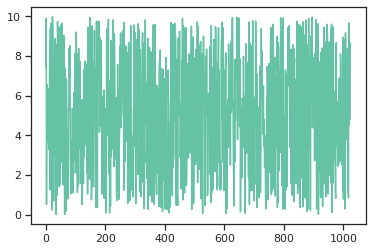

In [4]:
white_noize_ts = rng.uniform(0, 10, np.power(2, 10))
plt.plot(white_noize_ts)

In [5]:
print("DFA exponent for this White Noize sample: {}".format(nolds.dfa(white_noize_ts, order=1)))

DFA exponent for this White Noize sample: 0.5458074017364013


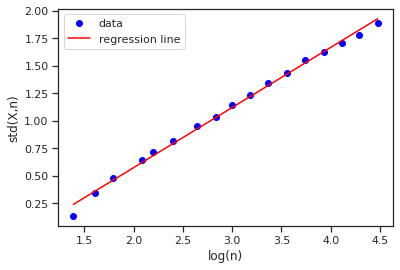

0.5458074017364013


In [6]:
(a_wn, debug_data) = nolds.dfa(white_noize_ts, debug_data=True, debug_plot=True)
print(a_wn)

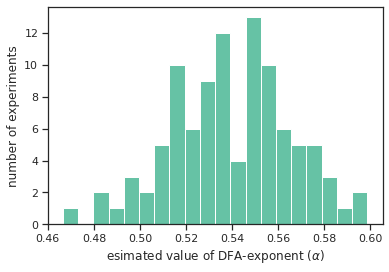

In [7]:
# nolds.examples.plot_hurst_hist()
a_wns = [nolds.dfa(rng.random(size=1000)) for _ in range(100)]
plt.hist(a_wns, bins=20)
plt.xlabel("esimated value of DFA-exponent ($\\alpha$)")
plt.ylabel("number of experiments")
plt.show()

In [0]:
wn_ps = np.abs(np.fft.rfft(white_noize_ts))**2

In [9]:
wn_res_lsq = least_squares(residuals, np.ones(2), args=(np.arange(1, len(wn_ps)), wn_ps[1:]))
b_wn = wn_res_lsq.x[1]
print("Power Spectrum Density beta exponent for White Noize sample: {}".format(b_wn))
print("alfa = {}, (beta + 1) / 2 = {}".format(a_wn, 0.5 * (b_wn + 1.0)))

Power Spectrum Density beta exponent for White Noize sample: 0.012144344054164749
alfa = 0.5458074017364013, (beta + 1) / 2 = 0.5060721720270823


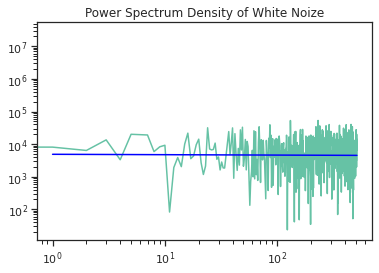

In [10]:
fitted_curve_lsq = f(np.arange(1, len(wn_ps)), wn_res_lsq.x)
plt.loglog(wn_ps)
plt.loglog(np.arange(1, len(wn_ps)), fitted_curve_lsq, c='blue')
plt.title("Power Spectrum Density of White Noize")
plt.show()

### Броуновское движение

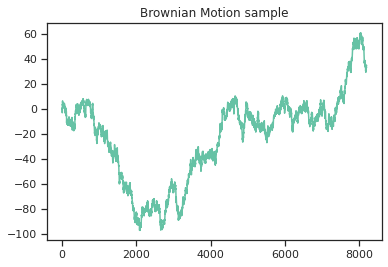

In [11]:
brownian_motion_ts = np.cumsum(rng.normal(size=np.power(2, 13)))
plt.plot(brownian_motion_ts)
plt.title("Brownian Motion sample")
plt.show()

In [12]:
print("DFA exponent for this Brownian motion sample: {}".format(nolds.dfa(brownian_motion_ts)))

DFA exponent for this Brownian motion sample: 1.5077892894456917


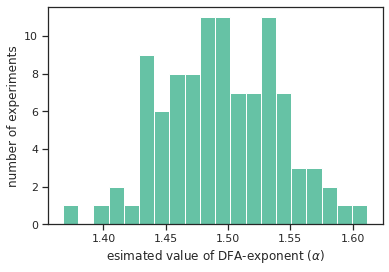

In [13]:
a_bw = [nolds.dfa(np.cumsum(rng.normal(size=1000))) for _ in range(100)]
plt.hist(a_bw, bins=20)
plt.xlabel("esimated value of DFA-exponent ($\\alpha$)")
plt.ylabel("number of experiments")
plt.show()

In [0]:
bm_ps = np.abs(np.fft.rfft(brownian_motion_ts))**2

In [15]:
bm_res_lsq = least_squares(residuals, np.ones(2), args=(np.arange(1, len(bm_ps)), bm_ps[1:]))
bm_beta = bm_res_lsq.x[1]
print("Power Spectrum Density beta exponent for Brownian motion sample: {}".format(bm_beta))

Power Spectrum Density beta exponent for Brownian motion sample: 1.783033144116217


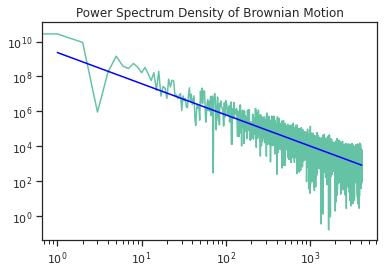

In [16]:
fitted_curve_lsq = f(np.arange(1, len(bm_ps)), bm_res_lsq.x)
plt.loglog(bm_ps)
plt.loglog(np.arange(1, len(bm_ps)), fitted_curve_lsq, c='blue')
plt.title("Power Spectrum Density of Brownian Motion")
plt.show()

### Обменный курс Евро к Доллару США

источник: [Официальный сайт ФРС США](https://www.federalreserve.gov/datadownload/Choose.aspx?rel=H10)

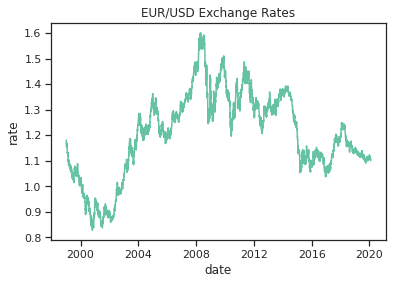

In [17]:
EurUsd_ts = pd.read_csv("https://raw.githubusercontent.com/vsilchev/hse-time-series/master/FRB_H10_EURUSD.csv",
                        parse_dates=['date'],
                        na_values='ND'
                        ).fillna(method='bfill')
sns.lineplot(x='date', y='rate', data=EurUsd_ts).set_title("EUR/USD Exchange Rates");

In [18]:
EurUsd_alpha = nolds.dfa(EurUsd_ts['rate'], order=2)
print("DFA exponent for EUR/USD exchange rates: {}".format(EurUsd_alpha))

DFA exponent for EUR/USD exchange rates: 1.5166184294187512


In [0]:
EurUsd_ps = np.abs(np.fft.rfft(EurUsd_ts['rate']))**2

In [20]:
res_lsq = least_squares(residuals, np.ones(2), args=(np.arange(1, len(EurUsd_ps)), EurUsd_ps[1:]))
EurUsd_beta = res_lsq.x[1]
print("Power Spectrum Density beta exponent for EUR/USD exchange rates: {}".format(EurUsd_beta))

Power Spectrum Density beta exponent for EUR/USD exchange rates: 1.827976047679742


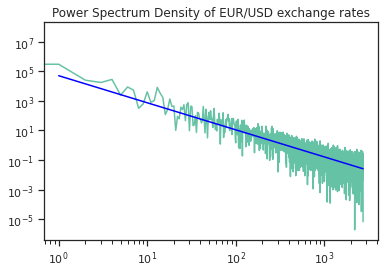

In [21]:
fitted_curve_lsq = f(np.arange(1, len(EurUsd_ps)), res_lsq.x)
plt.loglog(EurUsd_ps)
plt.loglog(np.arange(1, len(EurUsd_ps)), fitted_curve_lsq, c='blue')
plt.title("Power Spectrum Density of EUR/USD exchange rates")
plt.show()